<a href="https://colab.research.google.com/github/maritnorli/PyTorch-course/blob/main/02_neural_network_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural network classification with pytorch
Classification is a problem of predicting whether something is one thing or another (there can be multiple thisngs as the options)


In [4]:
## 1. Make classification data and get ready
import sklearn


In [5]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)



In [6]:
len(X), len(y)

(1000, 1000)

In [7]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")


First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [8]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [9]:
circles.label.value_counts()


1    500
0    500
Name: label, dtype: int64

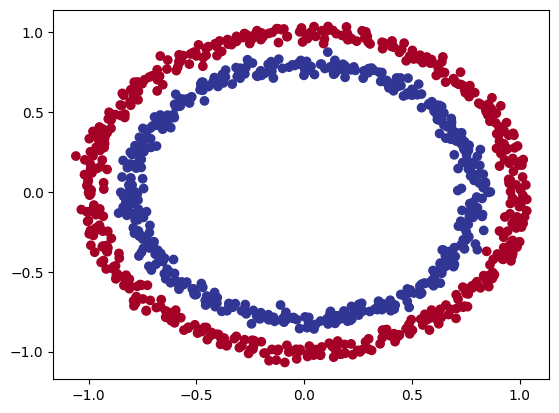

In [10]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);


Note: the data were working with is often reffered to as a toy dataset, a dataset that is small enough to experiment but still enough to practice fundamentals.

### 1.1 Check input and output shapes

In [11]:
X.shape, y.shape



((1000, 2), (1000,))

In [12]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [13]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")


Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [14]:
#Values for one sample of X: [**2 features of one trying to predict...**] and the same for y: *...one label of y*
#Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [15]:
# Turn data into tensors
import torch
torch.__version__

'2.1.0+cu121'

In [16]:
type(X), X.dtype #check type of X --> we want it in tensor, this is ndarray

(numpy.ndarray, dtype('float64'))

In [17]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float) #turning into torch.Tensor float 32


In [18]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [19]:
type(X), X.dtype, y.dtype #Check its torch.Tensor :D

(torch.Tensor, torch.float32, torch.float32)

In [20]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split #makes random split, remember use random seed(state)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 = 20% of data will be test andd 80% will be train
                                                    random_state=42)


In [21]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [22]:
n_samples

1000

## Building a model
Lets build a model to classify our blue and red dots.
To do so, we want to:
1. Setup device agnostic code, so code will run on gpu if it exist
2. construct a model(by subclassing `nn.Module`)
3. Defining a loss function and OptimizeResult
4. Create a training and test loop

In [23]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [24]:
X_train


tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Make a model
1. Subclasses `nn.Module`(almost all models in pytorch sublass nn
2. Create 2 `nn.Linear()`layers that are capable of handling the shapes of our data
3. Defines a `forward()`method that outlines the forward pass (or forward computatio) of the model
4. Instantiate an instance of our model class and send it to the target device



In [25]:
# 1. Construct a model that sublasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    # when sending data through linear layer it takes incoming data(x) through this equation y=xA(weigtht-tensor transposed) + b(bias) = y= xA^T + b
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from prev. layer and outputs a single feature (same shape as y)
    #self.layer_1 = nn.Linear(in_features=2, out_features=**5**) ** MUST MATCH
    #self.layer_2 = nn.Linear(in_features=**5**, out_features=1)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # the x goes into layer 1, the output of layer 1 goes into layer 2, then output of layer 2 goes into the output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [26]:
next(model_0.parameters()).device

device(type='cpu')

In [27]:
#playground.tensorflow.org
#figma.com

In [28]:
# Lets replicate the model above using nn.Sequential()
model_0= nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [29]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0882, -0.5003],
                      [ 0.1075, -0.0624],
                      [ 0.6327,  0.0412],
                      [ 0.2988, -0.5330],
                      [ 0.0748, -0.3399]])),
             ('0.bias', tensor([-0.0909, -0.0404,  0.3927, -0.5813,  0.5085])),
             ('1.weight',
              tensor([[-0.3922, -0.0253, -0.4446, -0.1781, -0.1238]])),
             ('1.bias', tensor([-0.2212]))])

In [30]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[ 0.0404],
        [-0.0207],
        [-0.1504],
        [ 0.0959],
        [-0.7073],
        [-0.7403],
        [-0.4708],
        [-0.6408],
        [-0.1266],
        [-0.0309]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [31]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function or optimzer should you use?
* for regression, you might want MAE or MSE
* For classification you might want binary entropy or cross entropy

As a reminder a loss function measures how wrong your predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however Pytorh has many built in operations.
* For different optimizers see torch.optim

In [32]:
# Setup the loss function
#loss_fn = nnBCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() #has sigmoid activation function built in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


In [33]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
#using accuracy as an evaluation method not just loss
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc


### 3. Train model
To train a model, build a training loop:
1. Forward pass
2. Calc loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer (grad descent)

### 3.1 Going from raw logits to prediction probabilities to prediction labels
Our model outputs are going to be raw **logits**
We can convert these **logits** into prediction probabilities by passing the to some kind of activation function (eg sigmoid for binary classification and softmax for multiclass classification

Then we can convert ou models probabilities to **predicion labels** by either rounding them or taking the `argmax()`


In [34]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0404],
        [-0.0207],
        [-0.1504],
        [ 0.0959],
        [-0.7073]])

In [35]:
y_test[:5] # the y_logits tensor above needs to be same format as y_test, but is not:

tensor([1., 0., 1., 0., 1.])

In [36]:
# To get tensors into same data format
# Use the sigmoid (on binary data) activation function on our model logits to turn them into prediction probabilities
# this is a required step
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5101],
        [0.4948],
        [0.4625],
        [0.5240],
        [0.3302]])

For our prediction probability vauel, we need to perform a range-style rounding on them
* `y_pred_probs`>= 0.5, `y=1` (class 1) (Everything equal to or above 0.5 is 1, and everything below 0.5 is 0)
* `y_pred_probs`< 0.5, `y=0` (class 0)

In [37]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs) #after sending the tensor through a sigmoid activation function it can be sent through a round function


In full all over again (logits -> pred prbs -> pred labels)
1. y_pred_labels = torch.round(torch.sigmoid(**the raw outputs of our model is logits**)[:5]))
2. y_pred_labels = torch.round(**turn logits into probabilities using sigmoid**(model_0(X_test.to(device))[:5]))
3. y_pred_labels = **turn probabilities into labels using round**(torch.sigmoid(model_0(X_test.to(device))[:5]))


In [38]:
# In full all over again (logits -> pred prbs -> pred labels)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze())) #(squeeze to get rid of an extra dimension)

y_preds.squeeze()



tensor([True, True, True, True, True])


tensor([1., 0., 0., 1., 0.])

In [39]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building and training and testing loop

In [40]:
#
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 100

# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. calculate the loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), #nn.BCELoss expects prediction probabilities as input
  #                y_train)

  loss = loss_fn(y_logits, #nn.BCEWithLogitsLoss expects raw logits as input
                 y_train
                 )
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (optimize parameters to reduce gradient, gradient descent)
  optimizer.step()

  ###. testing
  model_0.eval()
  with torch.inference_mode():
    #1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out whats happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, | Test acc: {test_acc:.2f}%") # % after 100 guesses, how many guesses our model gets right



Epoch: 0 | Loss 0.71779, Acc: 46.12% | Test loss: 0.71679, | Test acc: 44.00%
Epoch: 10 | Loss 0.70725, Acc: 48.62% | Test loss: 0.70810, | Test acc: 44.50%
Epoch: 20 | Loss 0.70264, Acc: 49.62% | Test loss: 0.70429, | Test acc: 48.00%
Epoch: 30 | Loss 0.70024, Acc: 49.62% | Test loss: 0.70223, | Test acc: 50.00%
Epoch: 40 | Loss 0.69877, Acc: 49.50% | Test loss: 0.70088, | Test acc: 50.00%
Epoch: 50 | Loss 0.69775, Acc: 49.25% | Test loss: 0.69987, | Test acc: 51.00%
Epoch: 60 | Loss 0.69698, Acc: 49.50% | Test loss: 0.69907, | Test acc: 50.50%
Epoch: 70 | Loss 0.69637, Acc: 49.50% | Test loss: 0.69840, | Test acc: 51.50%
Epoch: 80 | Loss 0.69588, Acc: 49.62% | Test loss: 0.69785, | Test acc: 51.50%
Epoch: 90 | Loss 0.69547, Acc: 49.38% | Test loss: 0.69738, | Test acc: 51.50%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isnt learning anything...
So to enspect it lets make some predictions and visualize

To do so, we're going to import a function called `plot_decision_boundary()`

https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py
     


In [41]:
import requests
from pathlib import Path

# Download helper functions from learn pytorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


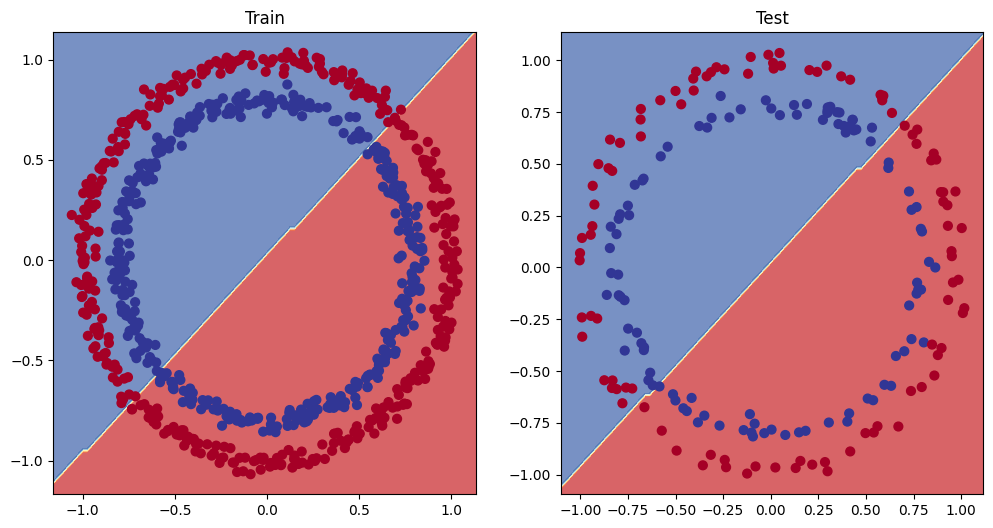

In [42]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)
* Add more layer - give it more chances to learn patterns in the data
* Add more hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

"These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as **hyperparameters**

Let's try and improve our model by:
Adding more hidden units: 5 -> 10
Increase the number of layers: 2 -> 3
Increase the number of epochs: 100 -> 1000"


In [43]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features = 10)
    self.layer_2 = nn.Linear(in_features=10, out_features = 10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    self.layer_3(self.layer_2(self.layer_1(x)))
    # z = self.layer_1(x)\n",
    # z = self.layer_2(z)\n",
    # z = self.layer_3(z) \n",
    # return z #z = logits vanlig bokstav)
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [44]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [45]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch = 1000

# put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test =  X_test.to(device), y_test.to(device)

for ecpoch in range(epochs):
  #train
  model_1.train()
  #forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  #calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Test

  model_1.eval()
  with torch.inference_mode():
    test_logits= model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calc loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 1000 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 1000 | Loss: 0.69392, Acc: 50.50% | Test loss: 0.69262, Test acc: 50.50%
Epoch: 1000 | Loss: 0.69389, Acc: 50.62% | Test loss: 0.69263, Test acc: 50.50%
Epoch: 1000 | Loss: 0.69386, Acc: 50.62% | Test loss: 0.69263, Test acc: 50.50%
Epoch: 1000 | Loss: 0.69383, Acc: 50.62% | Test loss: 0.69264, Test acc: 50.50%
Epoch: 1000 | Loss: 0.69381, Acc: 50.88% | Test loss: 0.69265, Test acc: 51.00%
Epoch: 1000 | Loss: 0.69378, Acc: 50.62% | Test loss: 0.69266, Test acc: 51.00%
Epoch: 1000 | Loss: 0.69376, Acc: 50.12% | Test loss: 0.69267, Test acc: 50.50%
Epoch: 1000 | Loss: 0.69373, Acc: 50.00% | Test loss: 0.69268, Test acc: 50.50%
Epoch: 1000 | Loss: 0.69371, Acc: 50.00% | Test loss: 0.69269, Test acc: 50.00%
Epoch: 1000 | Loss: 0.69369, Acc: 50.25% | Test loss: 0.69270, Test acc: 50.00%
Epoch: 1000 | Loss: 0.69367, Acc: 50.25% | Test loss: 0.69272, Test acc: 50.00%
Epoch: 1000 | Loss: 0.69365, Acc: 50.38%

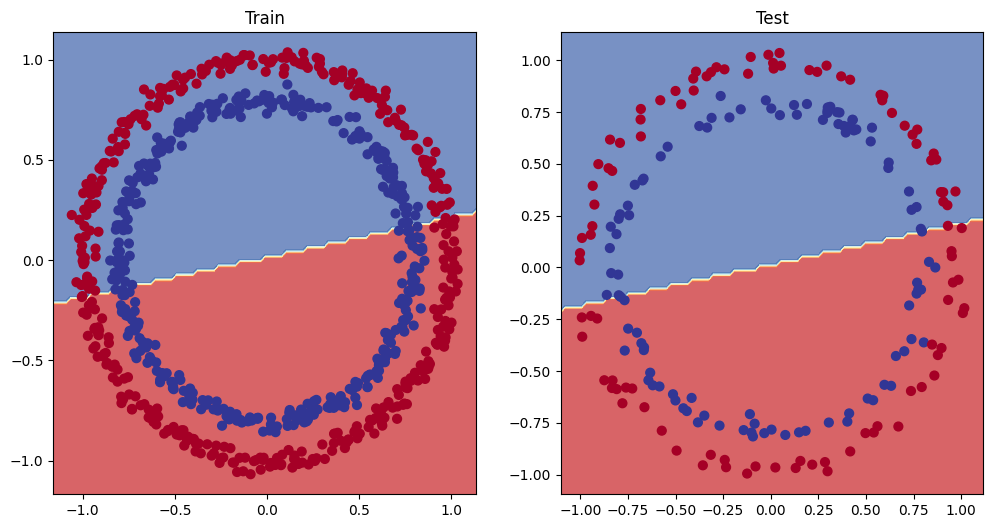

In [46]:
# Plot decision boundary of the model\n",
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

        "### 5.1 Preparing data to see if our model can fit a straight line
        
        "One way to troubleshoot to a larger problem is to test out a smaller problem."

        

In [47]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [48]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)


(80, 20, 80, 20)

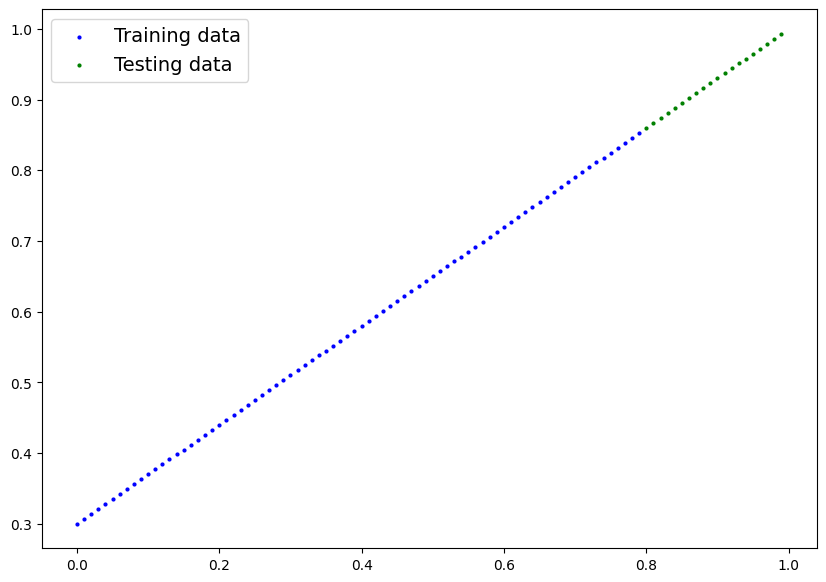

In [49]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);

### 5.2 Adjusting `model_1` to fit a straight line"

In [50]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
    ).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [51]:
# Loss and optimizer
loss_fn = nn.L1Loss() # MAE loss with regression data
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [52]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)
# Training\n",
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

# Testing\n",
model_2.eval()
with torch.inference_mode():
  test_pred = model_2(X_test_regression)
  test_loss = loss_fn(test_pred, y_test_regression)

# Print out what's happenin'
if epoch % 100 == 0:
  print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")



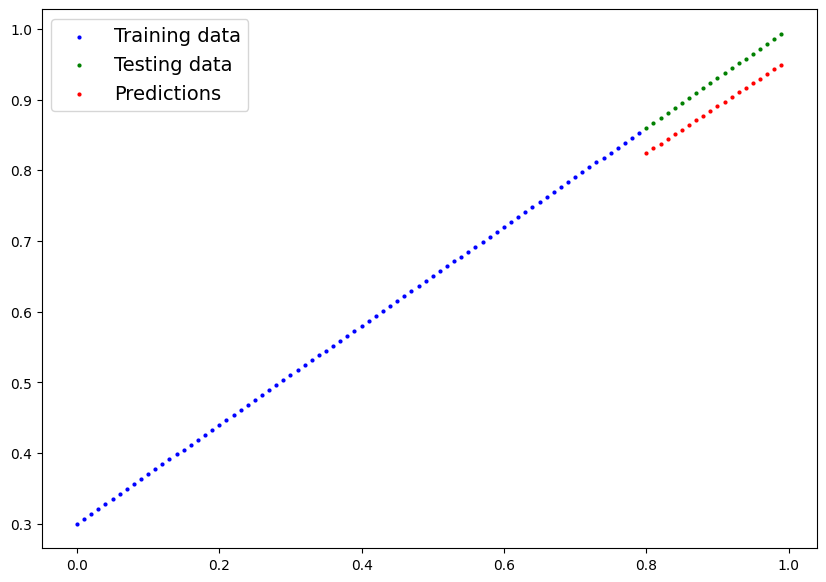

In [53]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity

What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?
or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions


### 6.1 Recreating non-linear data (red and blue circles)

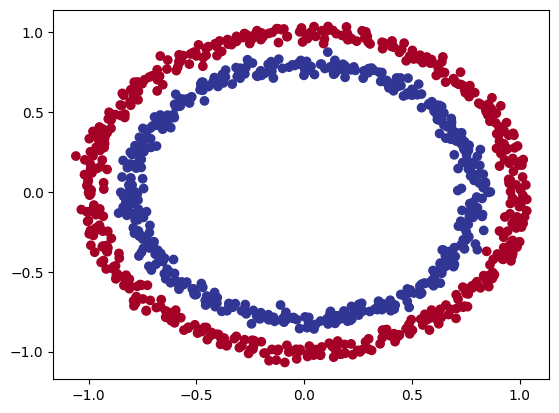

In [54]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [55]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors\n",
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets\n",
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]


(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

6.2 Building a model with non-linearity

* Linear = straight lines
* Non-linear = non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.


In [56]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module): #inherit from nn:module
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10) #hyperparameters, can be edited
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
  # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [57]:
## Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)


### 6.3 Training a model with non-linearity


In [58]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 2000

for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1. forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) #logits -> pred probs -> pred labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train) #BCEWithLogitsLoss
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Loss backward (back prop)
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out whats happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.6929, Acc: 50.00% | Test Loss: 0.6932, Test Acc: 50.00%
Epoch: 100 | Loss: 0.6912, Acc: 52.88% | Test Loss: 0.6910, Test Acc: 52.50%
Epoch: 200 | Loss: 0.6898, Acc: 53.37% | Test Loss: 0.6894, Test Acc: 55.00%
Epoch: 300 | Loss: 0.6879, Acc: 53.00% | Test Loss: 0.6872, Test Acc: 56.00%
Epoch: 400 | Loss: 0.6852, Acc: 52.75% | Test Loss: 0.6841, Test Acc: 56.50%
Epoch: 500 | Loss: 0.6810, Acc: 52.75% | Test Loss: 0.6794, Test Acc: 56.50%
Epoch: 600 | Loss: 0.6751, Acc: 54.50% | Test Loss: 0.6729, Test Acc: 56.00%
Epoch: 700 | Loss: 0.6666, Acc: 58.38% | Test Loss: 0.6632, Test Acc: 59.00%
Epoch: 800 | Loss: 0.6516, Acc: 64.00% | Test Loss: 0.6476, Test Acc: 67.50%
Epoch: 900 | Loss: 0.6236, Acc: 74.00% | Test Loss: 0.6215, Test Acc: 79.00%
Epoch: 1000 | Loss: 0.5682, Acc: 87.75% | Test Loss: 0.5738, Test Acc: 86.50%
Epoch: 1100 | Loss: 0.4815, Acc: 93.50% | Test Loss: 0.4993, Test Acc: 90.50%
Epoch: 1200 | Loss: 0.3706, Acc: 97.75% | Test Loss: 0.4059, Test Acc: 92.00

## 6.4 Evaluating model trained with non linear activation functions


In [59]:
# Make predictions with model_3
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

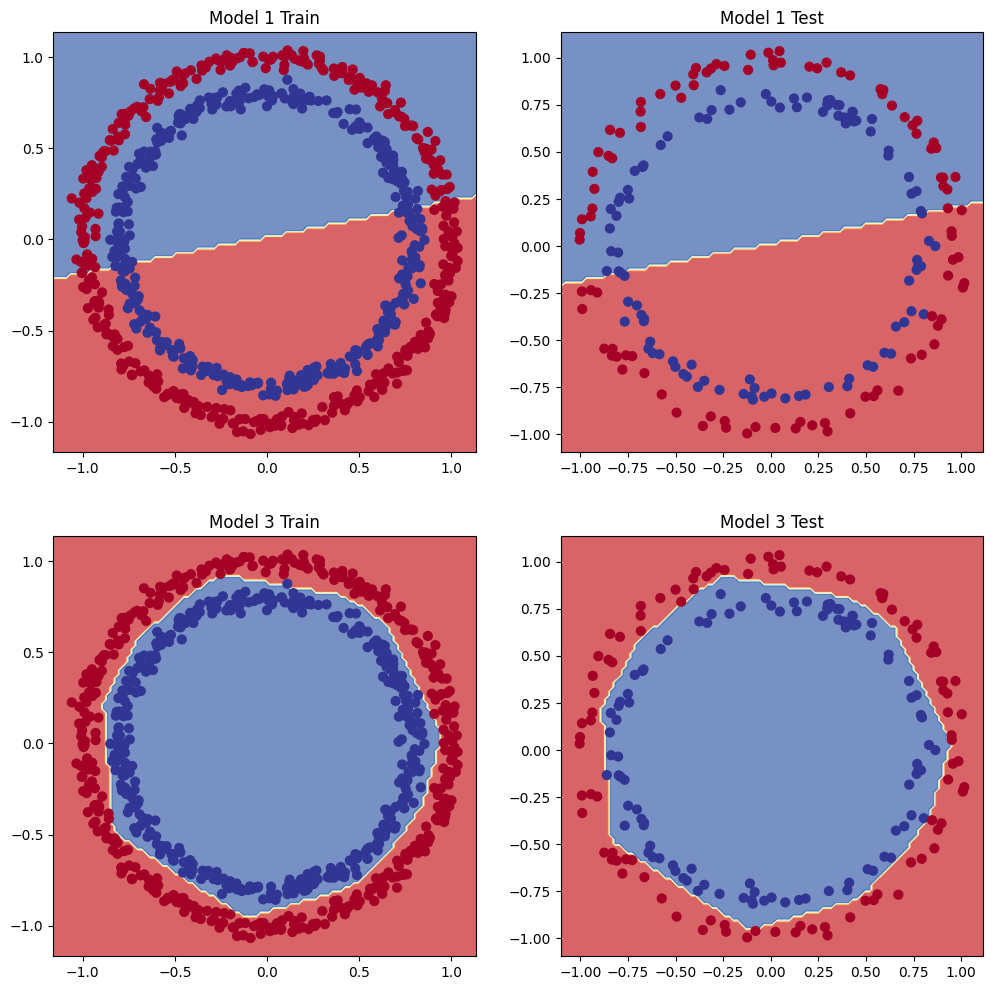

In [60]:
# Prlot descision boundaries
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.title("Model 1 Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(2, 2 ,2) #number of rows, number of colums, wher plott apears
plt.title("Model 1 Test")
plot_decision_boundary(model_1, X_test, y_test)

plt.subplot(2, 2, 3)
plt.title("Model 3 Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(2, 2 ,4) #number of rows, number of colums, wher plott apears
plt.title("Model 3 Test")
plot_decision_boundary(model_3, X_test, y_test)



## 7. Replicating non-linear activation functions
Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own
These tools are linear and non-linear functions


In [61]:
# Create a tensor
A = torch.arange(-10,10,1, dtype=torch.float32)
A.dtype

torch.float32

In [62]:
A



tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

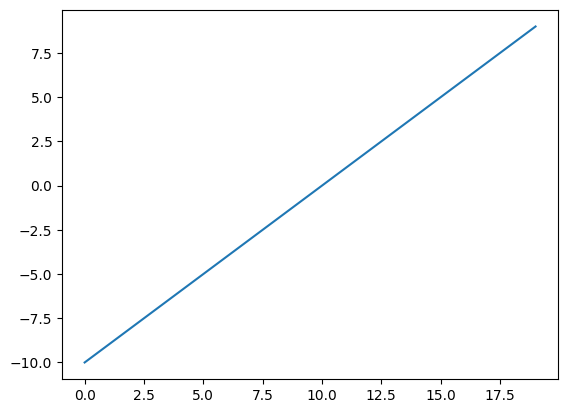

In [63]:
# Visualize data
plt.plot(A);

In [66]:
# Make our own verion of torch.relu() just to write it out and see
def myrelu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # input must be tensors

myrelu(A)



tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

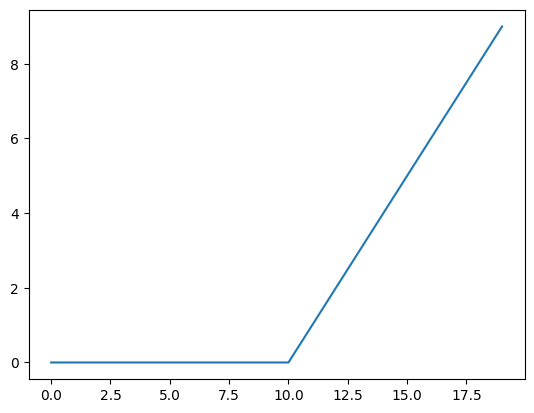

In [67]:
# plot our own relu activation function
plt.plot(myrelu(A))

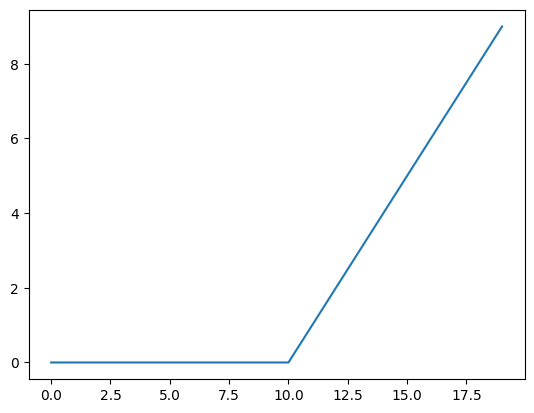

In [68]:
plt.plot(torch.relu(A)) #the torch verion of relu(A):

In [69]:
# The same for sigmoid, build our own sigmoid
def mysigmoid(x):
  return 1 / (1+torch.exp(-x))


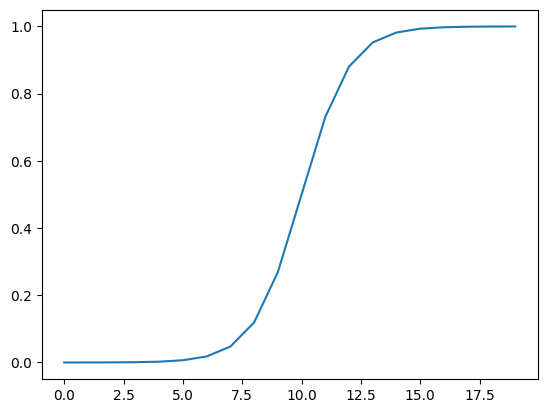

In [70]:
#plot our own sigmoid activation function
plt.plot(mysigmoid(A))

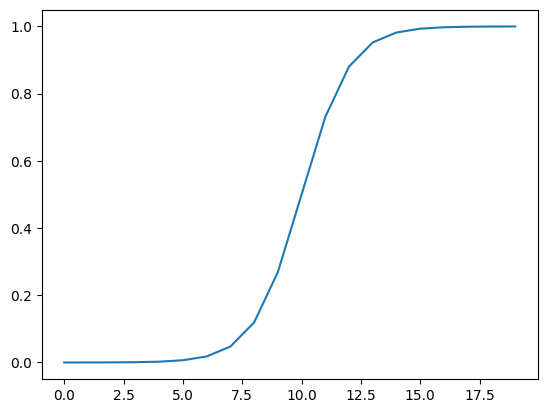

In [71]:
plt.plot(torch.sigmoid(A))

### Putting it all together: with a multi-class classification problem

* Bunary : one thing vs another (cat vs dog, spam or not spam etc)
* Multiclass: more than one (cat, dog, fish)


8.1 Creating a toy multi-class dataset

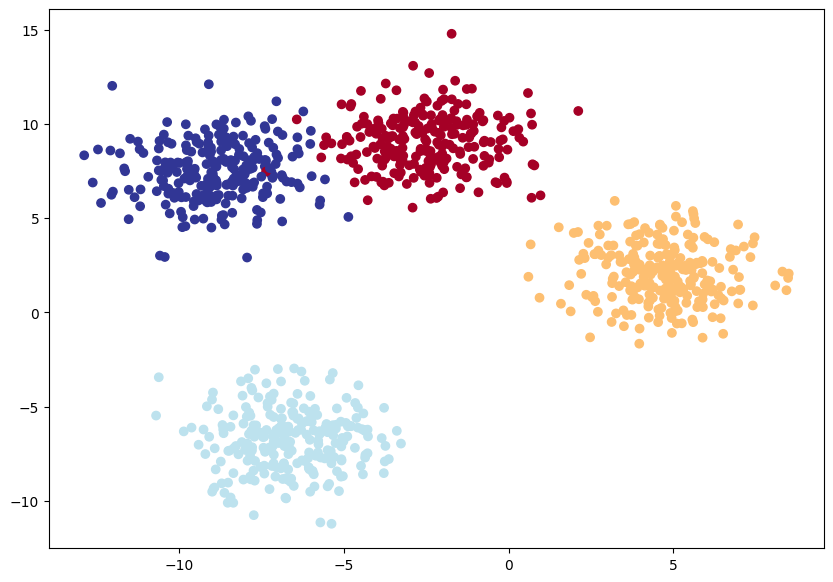

In [72]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # scikit-learn,
from sklearn.model_selection import train_test_split

# set the hyperparameters for data creation
# whenever hyperparameters are set in the start of a notebook its common to capitalize the letters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

#. !. create multi-class data with make_blobs from scikitlearn, is in numpy
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # shake them up a bit
                            random_state=RANDOM_SEED)
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float) #we pass in x_blob, turn it into float32
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) #

# 3. Slpit into training and test
#x's are features, y's are labels
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
#4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:,0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);




### 8.2 Building a multi-class classification model in pytorch


In [73]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [74]:
# Build a multiclass classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multiclass classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (classes)
      hidden_units (int): Number of hidden units between layers, default 8
    Returns:
    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

#create an instance of BlobModel and send it to target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4



BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [75]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [76]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3 Create loss function and optimizer for multi-class classification model


In [77]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi_class classification
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1) #learning rate is a hyperparameter you can change



### 8.4 Getting prediction probabilities for a pytorch model
In order to evaluate and test our model, we need to convert our models output (logits) to prediction probabilities and then to labels.

Logits (raw model output) -> pred probs (use `torch.softmax`) -> pred labels (take the argmax of the pred probs)

In [78]:
# lets get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [79]:
y_blob_test[:10]


tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [80]:
# Convert our models logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [81]:
torch.sum(y_pred_probs[0]) #All numbers on row 0 add up to 1!
#tensor([[**, 0.3244, 0.1405, 0.2182], **Whats the probability of the sample 1 (row 0) being class 1
#        [0.3336, **, 0.2026, 0.3206], **Whats the probability of the sample 2 being class 2
#        [0.3011, 0.1843, 0.2823, 0.2323],
#        [0.3078, 0.2766, 0.1836, 0.2320],
#        [0.3719, 0.1286, 0.1532, 0.3463]])

tensor(1.0000)

In [82]:
torch.max(y_pred_probs[0]) #highest prob of sample 1 (row 0)

tensor(0.3244)

In [83]:
torch.argmax(y_pred_probs[0]) #for sample 1 (row index 0) what class is the most fitting?
#answer: index 1 (index from 0-3 for classes 1-4), so class 2 is the best

tensor(1)

In [84]:
# convert our models prediction probabilities into labels
y_preds = torch.argmax(y_pred_probs, dim=1)

y_preds # should line up with the y_blob_test, (although still random, not trained yet)


tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [85]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

## 8.5 Create training and testing loop


In [86]:
#Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                  y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                         y_pred=test_preds)

  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 1.1588, Acc: 40.38% | Test loss: 1.0755, Test acc: 48.00%
Epoch: 10 | Loss: 0.6448, Acc: 96.75% | Test loss: 0.6607, Test acc: 97.50%
Epoch: 20 | Loss: 0.4254, Acc: 98.50% | Test loss: 0.4307, Test acc: 100.00%
Epoch: 30 | Loss: 0.2529, Acc: 99.12% | Test loss: 0.2451, Test acc: 99.50%
Epoch: 40 | Loss: 0.1123, Acc: 99.25% | Test loss: 0.1023, Test acc: 99.50%
Epoch: 50 | Loss: 0.0663, Acc: 99.25% | Test loss: 0.0585, Test acc: 99.50%
Epoch: 60 | Loss: 0.0507, Acc: 99.25% | Test loss: 0.0429, Test acc: 99.50%
Epoch: 70 | Loss: 0.0430, Acc: 99.25% | Test loss: 0.0349, Test acc: 99.50%
Epoch: 80 | Loss: 0.0384, Acc: 99.25% | Test loss: 0.0299, Test acc: 99.50%
Epoch: 90 | Loss: 0.0352, Acc: 99.25% | Test loss: 0.0266, Test acc: 99.50%
Epoch: 100 | Loss: 0.0331, Acc: 99.25% | Test loss: 0.0243, Test acc: 99.50%
Epoch: 110 | Loss: 0.0316, Acc: 99.25% | Test loss: 0.0226, Test acc: 99.50%
Epoch: 120 | Loss: 0.0304, Acc: 99.25% | Test loss: 0.0213, Test acc: 99.50%
Epoch: 13

### 8.6 Making and evaluating predictions with a pytorch multi-class model


In [87]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 preds
y_logits[:10]




tensor([[ -2.3751,  10.9387, -10.2038, -11.3271],
        [ -2.1934,  -9.4839,  -6.3062,   5.2289],
        [ -4.9855,  -5.3790,   5.3840,  -4.3115],
        [ -3.0428,   8.1532,  -5.4971,  -6.6867],
        [  6.4903,  -2.8975, -12.3324,  -8.4675],
        [ -2.7723, -11.1927,  -7.4741,   6.3901],
        [ -4.3608,  -4.5814,   4.6891,  -3.5910],
        [  5.8017,  -6.8308,  -9.7351,  -4.1265],
        [ -6.3789,  -6.9228,   6.6639,  -5.5251],
        [  6.2822,  -5.5357, -10.3558,  -5.4748]])

In [88]:
#Go from logits -> Pred probs
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10] #needs to look similar as y_blob_test

tensor([[1.6515e-06, 1.0000e+00, 6.5754e-10, 2.1385e-10],
        [5.9742e-04, 4.0741e-07, 9.7747e-06, 9.9939e-01],
        [3.1371e-05, 2.1165e-05, 9.9989e-01, 6.1552e-05],
        [1.3729e-05, 9.9998e-01, 1.1796e-06, 3.5901e-07],
        [9.9992e-01, 8.3726e-05, 6.6887e-09, 3.1906e-07],
        [1.0490e-04, 2.3112e-08, 9.5245e-07, 9.9989e-01],
        [1.1735e-04, 9.4120e-05, 9.9954e-01, 2.5340e-04],
        [9.9995e-01, 3.2638e-06, 1.7882e-07, 4.8777e-05],
        [2.1657e-06, 1.2571e-06, 9.9999e-01, 5.0863e-06],
        [9.9998e-01, 7.3709e-06, 5.9454e-08, 7.8339e-06]])

In [89]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [90]:
# Go from pred probs to prep balels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [91]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

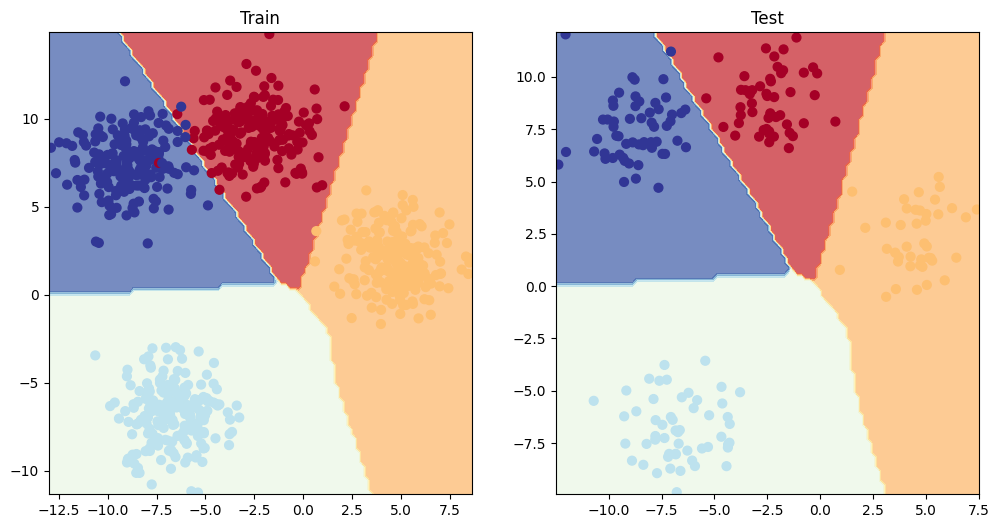

In [92]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)


### 9. A few more classification metrices (to evaluate our classification model)
* Accuracy - out of a hundred samples how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

See this article for when to use precision/recall - https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

If you want access to a lot of PyTorch metrics, see TorchMetrics - https://torchmetrics.readthedocs.io/en/latest/

In [93]:
!pip install torchmetrics

In [94]:
from torchmetrics import Accuracy
#This did not work at this time, but didnt seem super important in this vido

# Setup metric
torchmetric_accuracy = Accuracy().to(device)

# Calculuate accuracy
torchmetric_accuracy(y_preds, y_blob_test)


TypeError: Accuracy.__new__() missing 1 required positional argument: 'task'

In [ ]:
torchmetric_accuracy.device

## Exercises & Extra-curriculum

See exercises and extra-curriculum here: https://www.learnpytorch.io/02_pytorch_classification/#exercises
